# Visualize inversion results

Use this notebook to visualize some standard inversion results.

See `utils.py` for the code to generate plots and count observations in the region of interest (imported below).

Notebook can be accessed via AWS following these instructions: https://docs.aws.amazon.com/dlami/latest/devguide/setup-jupyter.html)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import yaml
import pickle as pickle
import pandas as pd
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
import colorcet as cc
from shapely.geometry.polygon import Polygon
import shapely.ops as ops
from functools import partial
import pyproj

from utils import plot_field, load_obj, calculate_gridcell_areas, sum_total_emissions, count_obs_in_mask

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

## Setup

In [2]:
# Read the configuration file
config = yaml.load(open("/home/ubuntu/integrated_methane_inversion/config.yml"), Loader=yaml.FullLoader)

In [3]:
# Open the state vector file
state_vector_filepath = './../StateVector.nc'
state_vector = xr.open_dataset(state_vector_filepath)
state_vector_labels = state_vector['StateVector']

# Identify the last element of the region of interest
last_ROI_element = int(np.nanmax(state_vector_labels.values) - config['nBufferClusters'])

# Define mask for region of interest
mask = (state_vector_labels <= last_ROI_element)

In [4]:
# Paths to prior emissions, inversion results, GEOS/satellite data, posterior simulation
prior_pth = f'./../jacobian_runs/{config["RunName"]}_0000/OutputDir/HEMCO_diagnostics.{config["StartDate"]}0000.nc'
results_pth = './gridded_posterior.nc'
satdat_dir = './data_converted'
inversion_result_path = './inversion_result.nc'
posterior_dir = './data_converted_posterior'

In [5]:
# Set latitude/longitude bounds for plots

# Trim 1 or 2 degrees to remove GEOS-Chem buffer zone
if config['Res'] == '0.25x0.3125':
    trim = 1
elif config['Res'] == '0.5x0.625':
    trim = 2

lon_bounds = [np.min(state_vector.lon.values)+trim, np.max(state_vector.lon.values)-trim]
lat_bounds = [np.min(state_vector.lat.values)+trim, np.max(state_vector.lat.values)-trim]

## State vector

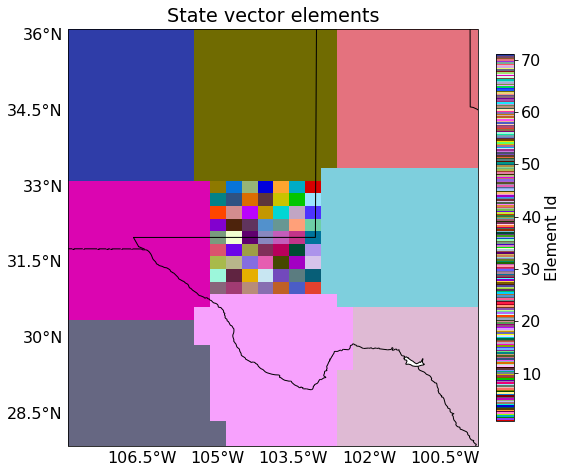

In [6]:
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, state_vector_labels, plot_type='imshow', cmap=cc.cm.glasbey, 
           title='State vector elements', cbar_label='Element Id')

## Prior and posterior emissions in the region of interest

In [7]:
# Prior emissions
prior = xr.open_dataset(prior_pth)['EmisCH4_Total'].isel(time=0)

# Optimized scale factors
scale = xr.open_dataset(results_pth)['ScaleFactor']

# Posterior emissions
posterior = prior * scale

In [8]:
# Total emissions in the region of interest

if config['Res'] == '0.25x0.3125':
    dlat=0.25/2
    dlon=0.3125/2
elif config['Res'] == '0.5x0.625':
    dlat=0.5/2
    dlon=0.625/2
    
areas = calculate_gridcell_areas(state_vector, mask, dlat, dlon)

total_prior_emissions = sum_total_emissions(prior, areas, state_vector_labels, last_ROI_element)
total_posterior_emissions = sum_total_emissions(posterior, areas, state_vector_labels, last_ROI_element)

print('Prior     emissions :', total_prior_emissions, 'Tg/y')
print('Posterior emissions :', total_posterior_emissions, 'Tg/y')

Prior     emissions : 0.3891754340499666 Tg/y
Posterior emissions : 0.9371880540323526 Tg/y


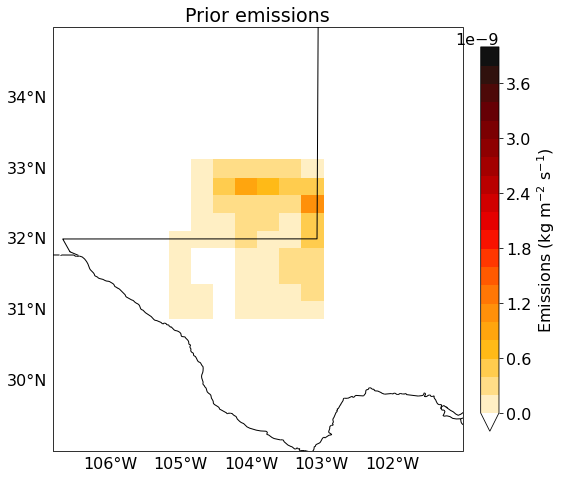

In [9]:
# Plot prior emissions
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, prior, cmap=cc.cm.linear_kryw_5_100_c67_r, 
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=4e-9, title='Prior emissions', cbar_label='Emissions (kg m$^{-2}$ s$^{-1}$)',
           only_ROI=True, state_vector_labels=state_vector_labels, last_ROI_element=last_ROI_element)

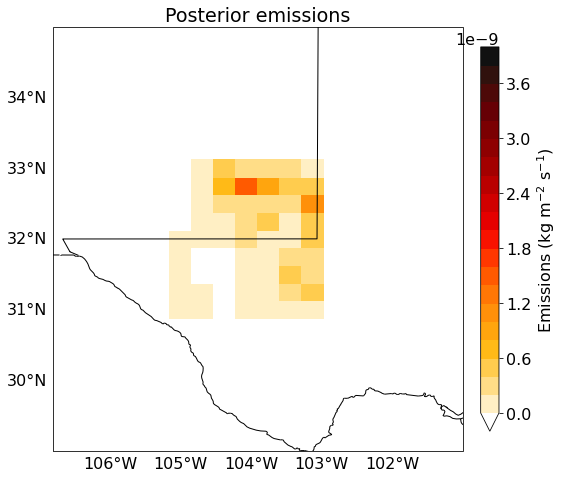

In [10]:
# Plot posterior emissions
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, posterior, cmap=cc.cm.linear_kryw_5_100_c67_r, 
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=4e-9, title='Posterior emissions', cbar_label='Emissions (kg m$^{-2}$ s$^{-1}$)',
           only_ROI=True, state_vector_labels=state_vector_labels, last_ROI_element=last_ROI_element)

## Scale factors

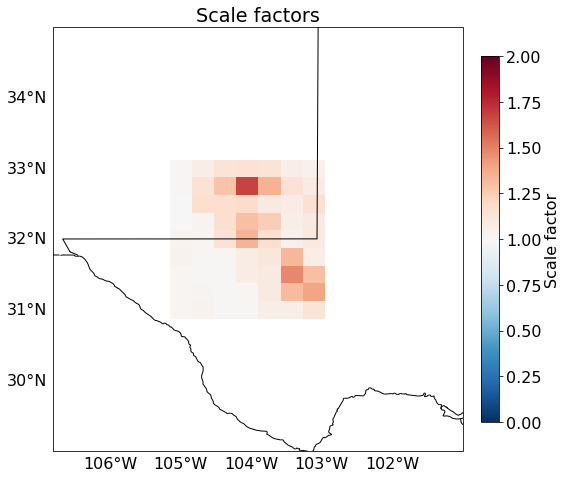

In [11]:
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, scale, cmap='RdBu_r', plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=2, title='Scale factors', cbar_label='Scale factor',
           only_ROI=True, state_vector_labels=state_vector_labels, last_ROI_element=last_ROI_element)

## Averaging kernel sensitivities

In [12]:
S_post_grid = xr.open_dataset(results_pth)['S_post']
A_grid = xr.open_dataset(results_pth)['A']
avkern_ROI = A_grid.where(state_vector_labels <= last_ROI_element)

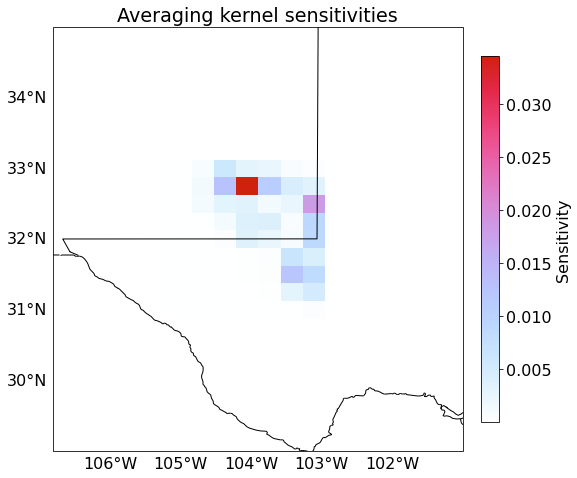

In [13]:
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, avkern_ROI, cmap=cc.cm.CET_L19, plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Averaging kernel sensitivities', cbar_label='Sensitivity', 
           only_ROI=True, state_vector_labels=state_vector_labels, last_ROI_element=last_ROI_element)

In [14]:
DOFS = np.nansum(avkern_ROI.values)
print('DOFS =', DOFS)

DOFS = 0.1863478674590624


## Open TROPOMI and GEOS-Chem columns

In [15]:
# Get observed and GEOS-Chem-simulated TROPOMI columns
files = np.sort(os.listdir(satdat_dir))
lat = np.array([])
lon = np.array([])
tropomi = np.array([])
geos_prior = np.array([])
geos_posterior = np.array([])

for f in files:
    # Get paths
    pth = os.path.join(satdat_dir,f)
    pth_posterior = os.path.join(posterior_dir,f)
    # Load TROPOMI/GEOS-Chem and Jacobian matrix data from the .pkl file
    obj = load_obj(pth)
    obj_posterior = load_obj(pth_posterior)
    # If there aren't any TROPOMI observations on this day, skip
    if obj['obs_GC'].shape[0] == 0:
        continue
    # Otherwise, grab the TROPOMI/GEOS-Chem data
    obs_GC = obj['obs_GC']
    obs_GC_posterior = obj_posterior['obs_GC']
    # Only consider data within latitude and longitude bounds
    ind = np.where((obs_GC[:,2]>=lon_bounds[0]) & (obs_GC[:,2]<=lon_bounds[1]) & 
                   (obs_GC[:,3]>=lat_bounds[0]) & (obs_GC[:,3]<=lat_bounds[1]))
    if (len(ind[0]) == 0):          # Skip if no data in bounds
        continue
    obs_GC = obs_GC[ind[0],:]       # TROPOMI and GEOS-Chem data within bounds
    obs_GC_posterior = obs_GC_posterior[ind[0],:]
    # Record lat, lon, tropomi ch4, and geos ch4
    lat = np.concatenate((lat, obs_GC[:,3]))
    lon = np.concatenate((lon, obs_GC[:,2]))
    tropomi = np.concatenate((tropomi, obs_GC[:,0]))
    geos_prior = np.concatenate((geos_prior, obs_GC[:,1]))
    geos_posterior = np.concatenate((geos_posterior, obs_GC_posterior[:,1]))
    
df = pd.DataFrame()
df['lat'] = lat
df['lon'] = lon
df['tropomi'] = tropomi
df['geos_prior'] = geos_prior
df['geos_posterior'] = geos_posterior
df['diff_tropomi_prior'] = geos_prior - tropomi
df['diff_tropomi_posterior'] = geos_posterior - tropomi
n_obs = len(tropomi)

print('Found',n_obs,'TROPOMI observations in the domain')
df.head()

Found 7799 TROPOMI observations in the domain


,lat,lon,tropomi,geos_prior,geos_posterior,diff_tropomi_prior,diff_tropomi_posterior
0,29.033932,-101.128197,1848.698853,1842.984375,1842.999756,-5.714478,-5.699097
1,29.011871,-101.371895,1850.213623,1840.976318,1840.990845,-9.237305,-9.222778
2,29.054628,-101.259598,1848.851074,1842.264526,1842.279419,-6.586548,-6.571655
3,29.096411,-101.148994,1850.255859,1842.652466,1842.669922,-7.603394,-7.585938
4,29.074257,-101.392967,1850.392090,1841.519531,1841.535034,-8.872559,-8.857056


Note: This observation count is for the lat/lon bounds defined in input cell 5.

In [16]:
# Print some error statistics
print('Bias in prior     :'  , np.round(df['diff_tropomi_prior'].mean(),2),'ppb')
print('Bias in posterior :'  , np.round(df['diff_tropomi_posterior'].mean(),2),'ppb')
print('RMSE prior        :'  , np.round(np.sqrt(np.mean(df['diff_tropomi_prior']**2)),2),'ppb')
print('RMSE posterior    :'  , np.round(np.sqrt(np.mean(df['diff_tropomi_posterior']**2)),2),'ppb')

Bias in prior     : -10.01 ppb
Bias in posterior : -6.37 ppb
RMSE prior        : 15.38 ppb
RMSE posterior    : 13.22 ppb


## Count observations within the region of interest

In [17]:
print('Found',count_obs_in_mask(mask, df),'observations within the region of interest')

Found 1548 observations within the region of interest


## Compare TROPOMI and GEOS-Chem columns

### Comparison at 0.1 x 0.1 resolution

In [18]:
# Simple averaging scheme to grid the XCH4 data at 0.1 x 0.1 resolution
df_copy = df.copy() # save for later
df['lat'] = np.round(df['lat'],1)
df['lon'] = np.round(df['lon'],1)
df = df.groupby(['lat','lon']).mean()
ds = df.to_xarray()

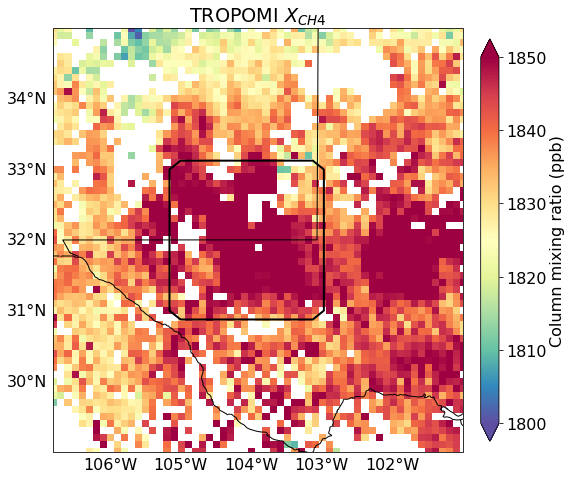

In [19]:
# Mean TROPOMI XCH4 columns on 0.1 x 0.1 grid
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, ds['tropomi'], cmap='Spectral_r', plot_type='imshow',
           vmin=1800, vmax=1850, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='TROPOMI $X_{CH4}$', cbar_label='Column mixing ratio (ppb)', 
           mask=mask, only_ROI=False)

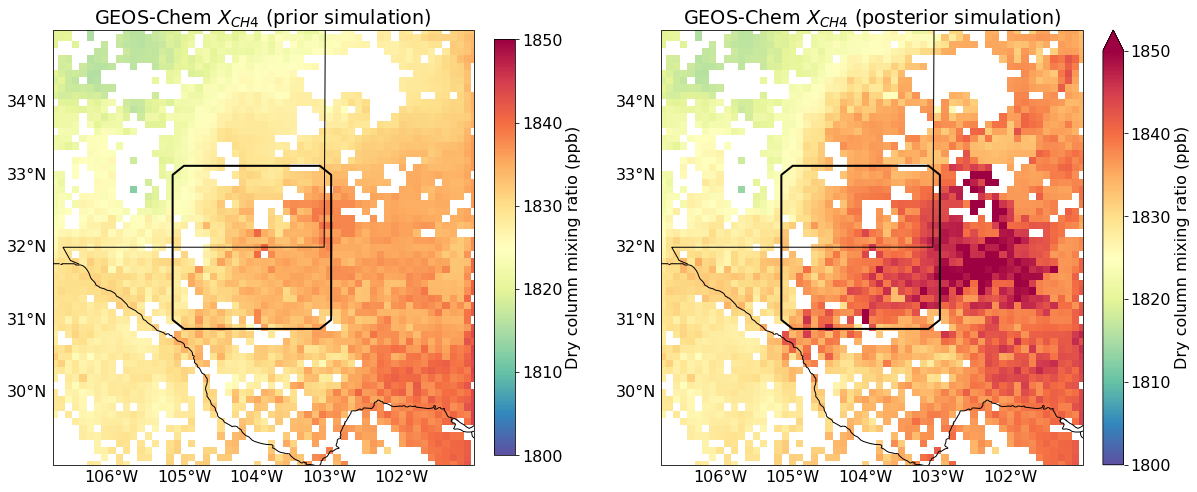

In [20]:
# Mean prior and posterior GEOS-Chem XCH4 columns on 0.1 x 0.1 grid
fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax1, ds['geos_prior'], cmap='Spectral_r', plot_type='imshow',
           vmin=1800, vmax=1850, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='GEOS-Chem $X_{CH4}$ (prior simulation)', cbar_label='Dry column mixing ratio (ppb)', 
           mask=mask, only_ROI=False)

plot_field(ax2, ds['geos_posterior'], cmap='Spectral_r', plot_type='imshow',
           vmin=1800, vmax=1850, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='GEOS-Chem $X_{CH4}$ (posterior simulation)', cbar_label='Dry column mixing ratio (ppb)', 
           mask=mask, only_ROI=False)

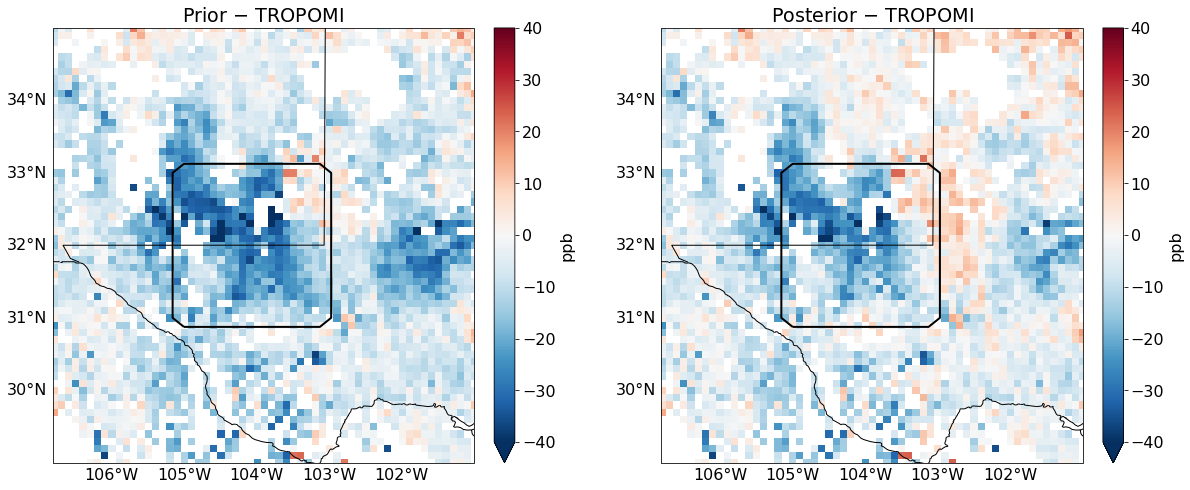

In [21]:
# Plot differences between GEOS-Chem and TROPOMI XCH4
fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax1, ds['diff_tropomi_prior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-40, vmax=40, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Prior $-$ TROPOMI', cbar_label='ppb', 
           mask=mask, only_ROI=False)

plot_field(ax2, ds['diff_tropomi_posterior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-40, vmax=40, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Posterior $-$ TROPOMI', cbar_label='ppb', 
           mask=mask, only_ROI=False)

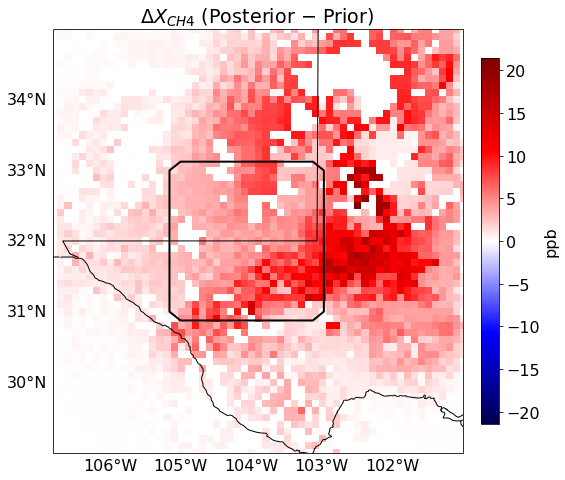

In [22]:
# Plot differences between posterior and prior simulated XCH4
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

diff = ds['geos_posterior']-ds['geos_prior']

plot_field(ax, diff, cmap='seismic', plot_type='imshow',
           vmin=-np.nanmax(diff),vmax=np.nanmax(diff),
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='$\Delta X_{CH4}$ (Posterior $-$ Prior)', cbar_label='ppb', 
           mask=mask, only_ROI=False)

### Comparison at 0.25 x 0.3125 resolution

In [23]:
# Global 0.25 x 0.3125 grid
reference_lat_grid = np.arange(-90 , 90+0.25   , 0.25)
reference_lon_grid = np.arange(-180, 180+0.3125, 0.3125)

# Find closest reference coordinates to selected lat/lon bounds
lat_min = reference_lat_grid[np.abs(reference_lat_grid - lat_bounds[0]).argmin()]
lon_min = reference_lon_grid[np.abs(reference_lon_grid - lon_bounds[0]).argmin()]
lat_max = reference_lat_grid[np.abs(reference_lat_grid - lat_bounds[1]).argmin()]
lon_max = reference_lon_grid[np.abs(reference_lon_grid - lon_bounds[1]).argmin()]

# Create an xESMF regridder object to resample the data on the grid HEMCO expects
new_lat_grid = np.arange(lat_min, lat_max+0.25, 0.25)
new_lon_grid = np.arange(lon_min, lon_max+0.3125, 0.3125)
ds_out = xr.Dataset({'lat': (['lat'], new_lat_grid),
                     'lon': (['lon'], new_lon_grid),
                    }
                   )

regridder = xe.Regridder(ds, ds_out, 'bilinear')

In [24]:
# Regrid the data
ds_regrid = regridder(ds)

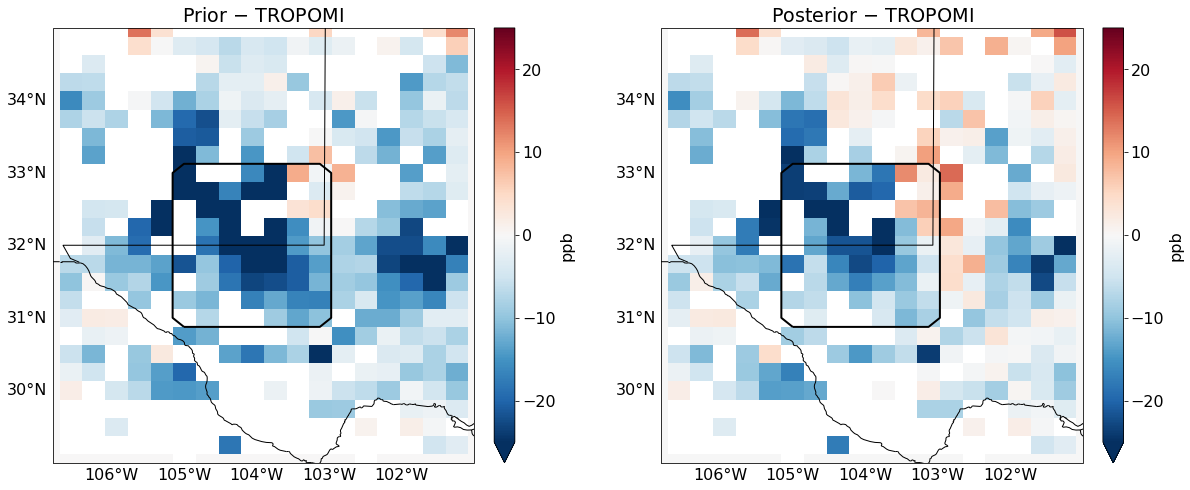

In [25]:
# Re-plot differences between GEOS-Chem and TROPOMI XCH4
fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax1, ds_regrid['diff_tropomi_prior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-25, vmax=25, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Prior $-$ TROPOMI', cbar_label='ppb', 
           mask=mask, only_ROI=False)

plot_field(ax2, ds_regrid['diff_tropomi_posterior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-25, vmax=25, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Posterior $-$ TROPOMI', cbar_label='ppb', 
           mask=mask, only_ROI=False)

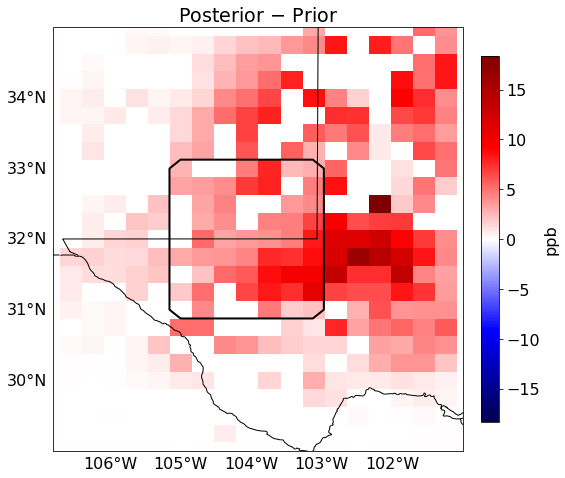

In [26]:
# Re-plot differences between posterior and prior simulated XCH4
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

diff_regrid = ds_regrid['geos_posterior']-ds_regrid['geos_prior']

plot_field(ax, diff_regrid, cmap='seismic', plot_type='imshow',
           vmin=-np.nanmax(diff_regrid),vmax=np.nanmax(diff_regrid), 
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Posterior $-$ Prior', cbar_label='ppb', 
           mask=mask, only_ROI=False)

----